Using device: cuda
Example 3.1: u = sin(πx₁)sin(πx₂)/(2π²)

Training DRM solver...
Epoch 50/3000 | Loss: 1.672260e-06 | Domain: -1.051269e-06 | Boundary: 2.723529e-06
Epoch 100/3000 | Loss: 9.845469e-07 | Domain: -1.259024e-06 | Boundary: 2.243570e-06
Epoch 150/3000 | Loss: 3.657626e-07 | Domain: -1.661094e-06 | Boundary: 2.026857e-06
Epoch 200/3000 | Loss: -2.852380e-07 | Domain: -2.311507e-06 | Boundary: 2.026269e-06
Epoch 250/3000 | Loss: -1.029860e-06 | Domain: -3.023602e-06 | Boundary: 1.993742e-06
Epoch 300/3000 | Loss: -1.752930e-06 | Domain: -3.690047e-06 | Boundary: 1.937117e-06
Epoch 350/3000 | Loss: -2.610606e-06 | Domain: -4.680903e-06 | Boundary: 2.070297e-06
Epoch 400/3000 | Loss: -3.648377e-06 | Domain: -5.668100e-06 | Boundary: 2.019723e-06
Epoch 450/3000 | Loss: -4.402787e-06 | Domain: -6.639502e-06 | Boundary: 2.236714e-06
Epoch 500/3000 | Loss: -5.286801e-06 | Domain: -7.817323e-06 | Boundary: 2.530521e-06
Epoch 550/3000 | Loss: -6.236311e-06 | Domain: -8.969690e-06 

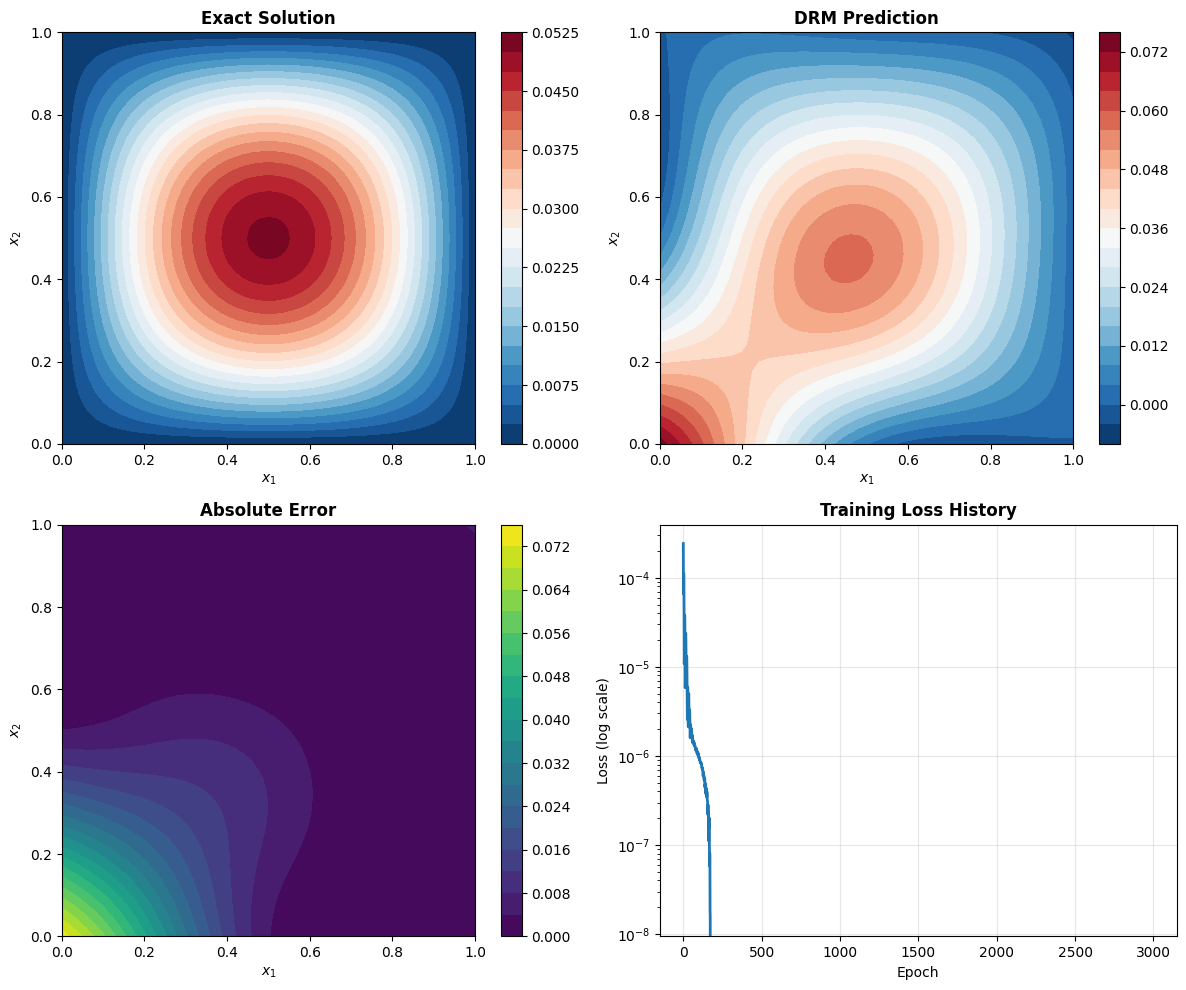

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class NeuralNetwork(nn.Module):
    """Deep neural network for approximating u_theta"""
    def __init__(self, input_dim=2, output_dim=1, layers=4, hidden_dim=64):
        super(NeuralNetwork, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Build network
        layer_list = []
        layer_list.append(nn.Linear(input_dim, hidden_dim))
        layer_list.append(nn.Tanh())
        
        for _ in range(layers - 2):
            layer_list.append(nn.Linear(hidden_dim, hidden_dim))
            layer_list.append(nn.Tanh())
        
        layer_list.append(nn.Linear(hidden_dim, output_dim))
        
        self.net = nn.Sequential(*layer_list)
    
    def forward(self, x):
        return self.net(x)

class BiharmonicP3Solver:
    """Deep Ritz Method solver for P3: simply supported boundary conditions"""
    def __init__(self, network, num_domain=1000, num_boundary=500, 
                 penalty=1e3, lr=1e-3):
        self.u_theta = network.to(device)
        self.num_domain = num_domain
        self.num_boundary = num_boundary
        self.penalty = penalty
        self.optimizer = torch.optim.Adam(self.u_theta.parameters(), lr=lr)
        self.history = []
    
    def sample_interior(self, n_samples):
        """Sample points uniformly from interior Ω = (0,1)²"""
        X = torch.rand(n_samples, 2, device=device)
        X.requires_grad_(True)
        return X
    
    def sample_boundary(self, n_samples):
        """Sample points uniformly from boundary ∂Ω with higher density at edge centers"""
        # Use stratified sampling with emphasis on edge centers
        Y = torch.zeros(n_samples, 2, device=device)
        samples_per_edge = n_samples // 4
        
        for edge in range(4):
            start_idx = edge * samples_per_edge
            end_idx = start_idx + samples_per_edge
            
            # Generate random values
            t = torch.rand(samples_per_edge, device=device)
            
            # Apply bias towards center using beta distribution-like transformation
            # This gives more samples near t=0.5 (edge centers)
            bias = 0.3  # Control concentration (higher = more concentrated at center)
            t = t * (1 - bias) + 0.5 * bias + (t - 0.5) * (1 - bias) * torch.sign(t - 0.5)
            t = torch.clamp(t, 0, 1)
            
            if edge == 0:  # x1=0, vary x2
                Y[start_idx:end_idx, 0] = 0.0
                Y[start_idx:end_idx, 1] = t
            elif edge == 1:  # x1=1, vary x2
                Y[start_idx:end_idx, 0] = 1.0
                Y[start_idx:end_idx, 1] = t
            elif edge == 2:  # x2=0, vary x1
                Y[start_idx:end_idx, 0] = t
                Y[start_idx:end_idx, 1] = 0.0
            else:  # x2=1, vary x1
                Y[start_idx:end_idx, 0] = t
                Y[start_idx:end_idx, 1] = 1.0
        
        Y.requires_grad_(True)
        return Y
    
    def compute_laplacian(self, u, x):
        """Compute Laplacian ∇²u"""
        grad_u = torch.autograd.grad(u.sum(), x, create_graph=True, retain_graph=True)[0]
        u_xx = torch.autograd.grad(grad_u[:, 0].sum(), x, create_graph=True, retain_graph=True)[0][:, 0]
        u_yy = torch.autograd.grad(grad_u[:, 1].sum(), x, create_graph=True, retain_graph=True)[0][:, 1]
        laplacian = u_xx + u_yy
        return laplacian
    
    def compute_normal_derivative(self, u, y):
        """Compute ∂u/∂n (normal derivative on boundary)"""
        grad_u = torch.autograd.grad(u.sum(), y, create_graph=True, retain_graph=True)[0]
        
        # Determine normal vector for each boundary point
        n_vec = torch.zeros_like(grad_u)
        
        tol = 1e-6
        # x1 = 0 edge, normal = (-1, 0)
        mask = y[:, 0] < tol
        n_vec[mask, 0] = -1.0
        
        # x1 = 1 edge, normal = (1, 0)
        mask = y[:, 0] > 1.0 - tol
        n_vec[mask, 0] = 1.0
        
        # x2 = 0 edge, normal = (0, -1)
        mask = y[:, 1] < tol
        n_vec[mask, 1] = -1.0
        
        # x2 = 1 edge, normal = (0, 1)
        mask = y[:, 1] > 1.0 - tol
        n_vec[mask, 1] = 1.0
        
        du_dn = (grad_u * n_vec).sum(dim=1)
        return du_dn
    
    def empirical_loss(self, X, Y, f, g1, g2):
        """
        Compute empirical loss for P3:
        L_λ = |Ω|/N Σ B_u(X_i) + |∂Ω|/M Σ [-g2(Y_j)∂u/∂n(Y_j) + λ/2(u-g1)²(Y_j)]
        where B_u(X) = 1/2|Δu(X)|² - f(X)u(X)
        """
        # Domain term
        u_X = self.u_theta(X)
        laplacian_X = self.compute_laplacian(u_X, X)
        
        B_u_X = 0.5 * laplacian_X**2 - f(X) * u_X.squeeze()
        
        # Clamp to avoid NaN
        B_u_X = torch.clamp(B_u_X, min=-1e8, max=1e8)
        domain_loss = (1.0 / self.num_domain) * B_u_X.mean()
        
        # Boundary term
        u_Y = self.u_theta(Y).squeeze()
        du_dn_Y = self.compute_normal_derivative(u_Y, Y)
        
        boundary_g2_term = -g2(Y) * du_dn_Y
        boundary_penalty = (self.penalty / 2) * (u_Y - g1(Y))**2
        
        # Clamp boundary terms
        boundary_g2_term = torch.clamp(boundary_g2_term, min=-1e8, max=1e8)
        boundary_penalty = torch.clamp(boundary_penalty, min=0, max=1e8)
        
        boundary_loss = (1.0 / self.num_boundary) * (boundary_g2_term + boundary_penalty).mean()
        
        total_loss = domain_loss + boundary_loss
        return total_loss, domain_loss, boundary_loss
    
    def train(self, f, g1, g2, epochs=500):
        """Train the network using Adam"""
        for epoch in range(epochs):
            # Sample points
            X = self.sample_interior(self.num_domain)
            Y = self.sample_boundary(self.num_boundary)
            
            # Zero gradients
            self.optimizer.zero_grad()
            
            # Compute loss
            loss, loss_domain, loss_boundary = self.empirical_loss(X, Y, f, g1, g2)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.u_theta.parameters(), max_norm=1.0)
            
            # Optimizer step
            self.optimizer.step()
            
            self.history.append(loss.item())
            
            if (epoch + 1) % 50 == 0:
                print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.6e} | "
                      f"Domain: {loss_domain.item():.6e} | Boundary: {loss_boundary.item():.6e}")
    
    def evaluate(self, x_test):
        """Evaluate network at test points"""
        x_tensor = torch.tensor(x_test, dtype=torch.float32, device=device)
        with torch.no_grad():
            u_pred = self.u_theta(x_tensor).cpu().numpy()
        return u_pred

# Example 3.1: u = sin(πx₁)sin(πx₂)/(2π²)
print("=" * 70)
print("Example 3.1: u = sin(πx₁)sin(πx₂)/(2π²)")
print("=" * 70)

# Exact solution
def u_exact(x):
    return np.sin(np.pi * x[:, 0]) * np.sin(np.pi * x[:, 1]) / (2 * np.pi**2)

# Right-hand side f = Δ²u
def f(x):
    x_np = x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x
    return torch.tensor(4 * np.pi**4 * np.sin(np.pi * x_np[:, 0]) * 
                      np.sin(np.pi * x_np[:, 1]) / (2 * np.pi**2), 
                      dtype=torch.float32, device=device)

# Boundary conditions: g1 = u, g2 = Δu on ∂Ω
def g1(y):
    y_np = y.detach().cpu().numpy()
    return torch.tensor(u_exact(y_np), dtype=torch.float32, device=device).squeeze()

def g2(y):
    y_np = y.detach().cpu().numpy()
    # g2 = Δu on boundary = -2π²u on boundary
    return torch.tensor(-2 * np.pi**2 * np.sin(np.pi * y_np[:, 0]) * 
                       np.sin(np.pi * y_np[:, 1]) / (2 * np.pi**2),
                      dtype=torch.float32, device=device)

# Create solver
network = NeuralNetwork(layers=5, hidden_dim=128)
solver = BiharmonicP3Solver(network, num_domain=8000, num_boundary=3000, 
                           penalty=1e3, lr=1e-4)

print("\nTraining DRM solver...")
solver.train(f, g1, g2, epochs=3000)

# Evaluate on grid
print("\nEvaluating on grid...")
x = np.linspace(0, 1, 51)
y = np.linspace(0, 1, 51)
X_grid, Y_grid = np.meshgrid(x, y)
X_test = np.column_stack([X_grid.ravel(), Y_grid.ravel()])

u_pred = solver.evaluate(X_test).reshape(X_grid.shape)
u_exact_grid = u_exact(X_test).reshape(X_grid.shape)
error = np.abs(u_pred - u_exact_grid)

# Compute errors
l2_error = np.sqrt(np.mean(error**2))
l2_exact = np.sqrt(np.mean(u_exact_grid**2))
l2_relative = l2_error / l2_exact

print(f"\n" + "=" * 70)
print("RESULTS FOR EXAMPLE 3.1")
print("=" * 70)
print(f"L² Error: {l2_error:.6e}")
print(f"L² Relative Error: {l2_relative:.6e}")
print(f"Maximum Absolute Error: {np.max(error):.6e}")
print(f"Mean Absolute Error: {np.mean(error):.6e}")

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Exact solution
im0 = axes[0, 0].contourf(X_grid, Y_grid, u_exact_grid, 20, cmap='RdBu_r')
axes[0, 0].set_title('Exact Solution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('$x_1$')
axes[0, 0].set_ylabel('$x_2$')
plt.colorbar(im0, ax=axes[0, 0])

# DRM prediction
im1 = axes[0, 1].contourf(X_grid, Y_grid, u_pred, 20, cmap='RdBu_r')
axes[0, 1].set_title('DRM Prediction', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('$x_1$')
axes[0, 1].set_ylabel('$x_2$')
plt.colorbar(im1, ax=axes[0, 1])

# Absolute error
im2 = axes[1, 0].contourf(X_grid, Y_grid, error, 20, cmap='viridis')
axes[1, 0].set_title('Absolute Error', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('$x_1$')
axes[1, 0].set_ylabel('$x_2$')
plt.colorbar(im2, ax=axes[1, 0])

# Training history
axes[1, 1].semilogy(solver.history, linewidth=2)
axes[1, 1].set_title('Training Loss History', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss (log scale)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('example_3_1_results.png', dpi=150, bbox_inches='tight')
print("\nPlot saved as 'example_3_1_results.png'")
plt.show()

In [3]:
import numpy as np

def compute_error_metrics(u_exact_grid, u_pred_grid, dx=1.0/50):
    """
    Compute L2, H1, and H2 error metrics and their relative versions.
    
    Parameters:
    -----------
    u_exact_grid : ndarray
        Exact solution on grid (shape: grid_size x grid_size)
    u_pred_grid : ndarray
        Predicted solution on grid (shape: grid_size x grid_size)
    dx : float
        Grid spacing (default: 1/50 for 51x51 grid)
    
    Returns:
    --------
    dict : Dictionary containing all error metrics
    """
    
    # Pointwise error
    error = np.abs(u_exact_grid - u_pred_grid)
    
    # =========================================================================
    # L2 ERRORS
    # =========================================================================
    # L2 error: ||u - u_θ||_L2(Ω)
    error_L2 = np.sqrt(np.sum(error**2) * dx**2)
    
    # L2 norm of exact solution: ||u||_L2(Ω)
    norm_u_L2 = np.sqrt(np.sum(u_exact_grid**2) * dx**2)
    
    # L2 relative error: ||u - u_θ||_L2 / ||u||_L2
    l2_relative = error_L2 / norm_u_L2
    
    # =========================================================================
    # H1 ERRORS (includes gradients)
    # =========================================================================
    # Compute gradients
    grad_u_exact = np.gradient(u_exact_grid, dx, axis=[0, 1])
    grad_u_pred = np.gradient(u_pred_grid, dx, axis=[0, 1])
    
    # Gradient error: ||∇(u - u_θ)||_L2(Ω)
    grad_error = np.sqrt(np.sum((grad_u_exact[0] - grad_u_pred[0])**2 + 
                                 (grad_u_exact[1] - grad_u_pred[1])**2) * dx**2)
    
    # Energy error: ||u - u_θ||_L2 + ||∇(u - u_θ)||_L2
    energy_error = error_L2 + grad_error
    
    # L2 norm of gradient: ||∇u||_L2(Ω)
    norm_grad_u_L2 = np.sqrt(np.sum(grad_u_exact[0]**2 + grad_u_exact[1]**2) * dx**2)
    
    # H1 norm: ||u||_H1(Ω) = ||u||_L2 + ||∇u||_L2
    norm_u_H1 = norm_u_L2 + norm_grad_u_L2
    
    # H1 relative error: (||u - u_θ||_L2 + ||∇(u - u_θ)||_L2) / (||u||_L2 + ||∇u||_L2)
    h1_relative = energy_error / norm_u_H1
    
    # =========================================================================
    # H2 ERRORS (includes second derivatives)
    # =========================================================================
    # Compute second derivatives
    hess_u_exact_xx = np.gradient(grad_u_exact[0], dx, axis=0)
    hess_u_exact_yy = np.gradient(grad_u_exact[1], dx, axis=1)
    hess_u_pred_xx = np.gradient(grad_u_pred[0], dx, axis=0)
    hess_u_pred_yy = np.gradient(grad_u_pred[1], dx, axis=1)
    
    # Second derivative error: ||D²(u - u_θ)||_L2(Ω)
    second_deriv_error = np.sqrt(np.sum((hess_u_exact_xx - hess_u_pred_xx)**2 + 
                                         (hess_u_exact_yy - hess_u_pred_yy)**2) * dx**2)
    
    # H2 error: ||u - u_θ||_H2(Ω)
    h2_error = np.sqrt(error_L2**2 + grad_error**2 + second_deriv_error**2)
    
    # L2 norm of second derivatives: ||D²u||_L2(Ω)
    norm_second_deriv_u_L2 = np.sqrt(np.sum(hess_u_exact_xx**2 + hess_u_exact_yy**2) * dx**2)
    
    # H2 norm: ||u||_H2(Ω) = ||u||_L2 + ||∇u||_L2 + ||D²u||_L2
    norm_u_H2 = norm_u_L2 + norm_grad_u_L2 + norm_second_deriv_u_L2
    
    # H2 relative error: ||u - u_θ||_H2 / ||u||_H2
    h2_relative = h2_error / norm_u_H2
    
    # =========================================================================
    # Return all metrics as dictionary
    # =========================================================================
    metrics = {
        # L2 Errors
        'error_L2': error_L2,
        'l2_relative': l2_relative,
        
        # H1 Errors (Energy)
        'energy_error': energy_error,
        'h1_relative': h1_relative,
        
        # H2 Errors
        'h2_error': h2_error,
        'h2_relative': h2_relative,
        
        # Norms
        'norm_u_L2': norm_u_L2,
        'norm_grad_u_L2': norm_grad_u_L2,
        'norm_second_deriv_u_L2': norm_second_deriv_u_L2,
        'norm_u_H1': norm_u_H1,
        'norm_u_H2': norm_u_H2,
        
        # Component errors
        'grad_error': grad_error,
        'second_deriv_error': second_deriv_error,
        
        # Additional
        'max_error': np.max(error),
        'mean_error': np.mean(error)
    }
    
    return metrics


def print_error_report(metrics):
    """
    Print a formatted error report.
    
    Parameters:
    -----------
    metrics : dict
        Dictionary returned from compute_error_metrics()
    """
    print("\n" + "=" * 70)
    print("ERROR METRICS REPORT")
    print("=" * 70)
    
    print(f"\nL² ERRORS:")
    print(f"  ||u - u_θ||_L2(Ω):           {metrics['error_L2']:.6e}")
    print(f"  L² Relative Error:           {metrics['l2_relative']:.6e}")
    
    print(f"\nENERGY/H¹ ERRORS:")
    print(f"  ||u - u_θ||_L2 + ||∇(u - u_θ)||_L2:  {metrics['energy_error']:.6e}")
    print(f"  H¹ Relative Error:                    {metrics['h1_relative']:.6e}")
    
    print(f"\nH² ERRORS:")
    print(f"  ||u - u_θ||_H2(Ω):           {metrics['h2_error']:.6e}")
    print(f"  H² Relative Error:           {metrics['h2_relative']:.6e}")
    
    print(f"\nNORM VALUES (for reference):")
    print(f"  ||u||_L2(Ω):                 {metrics['norm_u_L2']:.6e}")
    print(f"  ||∇u||_L2(Ω):                {metrics['norm_grad_u_L2']:.6e}")
    print(f"  ||D²u||_L2(Ω):               {metrics['norm_second_deriv_u_L2']:.6e}")
    print(f"  ||u||_H1(Ω):                 {metrics['norm_u_H1']:.6e}")
    print(f"  ||u||_H2(Ω):                 {metrics['norm_u_H2']:.6e}")
    
    print(f"\nCOMPONENT ERRORS:")
    print(f"  ||∇(u - u_θ)||_L2:           {metrics['grad_error']:.6e}")
    print(f"  ||D²(u - u_θ)||_L2:          {metrics['second_deriv_error']:.6e}")
    
    print(f"\nADDITIONAL METRICS:")
    print(f"  Maximum Absolute Error:      {metrics['max_error']:.6e}")
    print(f"  Mean Absolute Error:         {metrics['mean_error']:.6e}")
    print("=" * 70)


# =========================================================================
# USAGE EXAMPLE
# =========================================================================
if __name__ == "__main__":
    # Example: Generate synthetic data
    x = np.linspace(0, 1, 51)
    y = np.linspace(0, 1, 51)
    X_grid, Y_grid = np.meshgrid(x, y)
    
    # Exact solution
    u_exact_grid = np.sin(np.pi * X_grid) * np.sin(np.pi * Y_grid) / (2 * np.pi**2)
    
    # Predicted solution (with small noise for demonstration)
    u_pred_grid = u_exact_grid + 0.001 * np.random.randn(*u_exact_grid.shape)
    
    # Compute metrics
    metrics = compute_error_metrics(u_exact_grid, u_pred_grid, dx=1.0/50)
    
    # Print report
    print_error_report(metrics)
    
    # Access individual metrics
    print(f"\nDirect access example:")
    print(f"L2 Relative Error: {metrics['l2_relative']:.6e}")
    print(f"H1 Relative Error: {metrics['h1_relative']:.6e}")
    print(f"H2 Relative Error: {metrics['h2_relative']:.6e}")


ERROR METRICS REPORT

L² ERRORS:
  ||u - u_θ||_L2(Ω):           1.022044e-03
  L² Relative Error:           4.034867e-02

ENERGY/H¹ ERRORS:
  ||u - u_θ||_L2 + ||∇(u - u_θ)||_L2:  5.453423e-02
  H¹ Relative Error:                    3.894661e-01

H² ERRORS:
  ||u - u_θ||_H2(Ω):           2.354520e+00
  H² Relative Error:           4.774688e+00

NORM VALUES (for reference):
  ||u||_L2(Ω):                 2.533030e-02
  ||∇u||_L2(Ω):                1.146928e-01
  ||D²u||_L2(Ω):               3.531023e-01
  ||u||_H1(Ω):                 1.400231e-01
  ||u||_H2(Ω):                 4.931254e-01

COMPONENT ERRORS:
  ||∇(u - u_θ)||_L2:           5.351219e-02
  ||D²(u - u_θ)||_L2:          2.353911e+00

ADDITIONAL METRICS:
  Maximum Absolute Error:      3.389133e-03
  Mean Absolute Error:         7.915428e-04

Direct access example:
L2 Relative Error: 4.034867e-02
H1 Relative Error: 3.894661e-01
H2 Relative Error: 4.774688e+00


Using device: cuda
Example 3.2: u = x₁²x₂²(1-x₁)²(1-x₂)²

Training DRM solver...
Epoch 50/3000 | Loss: 1.705154e-01 | Domain: -2.969436e-06 | Boundary: 1.705183e-01 | LR: 1.000000e-02
Epoch 100/3000 | Loss: 2.071822e-01 | Domain: 4.484395e-07 | Boundary: 2.071817e-01 | LR: 1.000000e-02
Epoch 150/3000 | Loss: 2.385983e-01 | Domain: -4.142724e-06 | Boundary: 2.386024e-01 | LR: 1.000000e-02
Epoch 200/3000 | Loss: 1.675250e-02 | Domain: -1.730711e-07 | Boundary: 1.675267e-02 | LR: 9.000000e-03
Epoch 250/3000 | Loss: 1.359971e-01 | Domain: -9.284555e-07 | Boundary: 1.359980e-01 | LR: 9.000000e-03
Epoch 300/3000 | Loss: 1.974632e-04 | Domain: -1.844634e-07 | Boundary: 1.976477e-04 | LR: 9.000000e-03
Epoch 350/3000 | Loss: 5.369461e-04 | Domain: -2.019970e-07 | Boundary: 5.371481e-04 | LR: 9.000000e-03
Epoch 400/3000 | Loss: 1.991006e-06 | Domain: 1.830488e-08 | Boundary: 1.972701e-06 | LR: 8.100000e-03
Epoch 450/3000 | Loss: 2.896787e-08 | Domain: -1.860934e-09 | Boundary: 3.082881e-08 | LR:

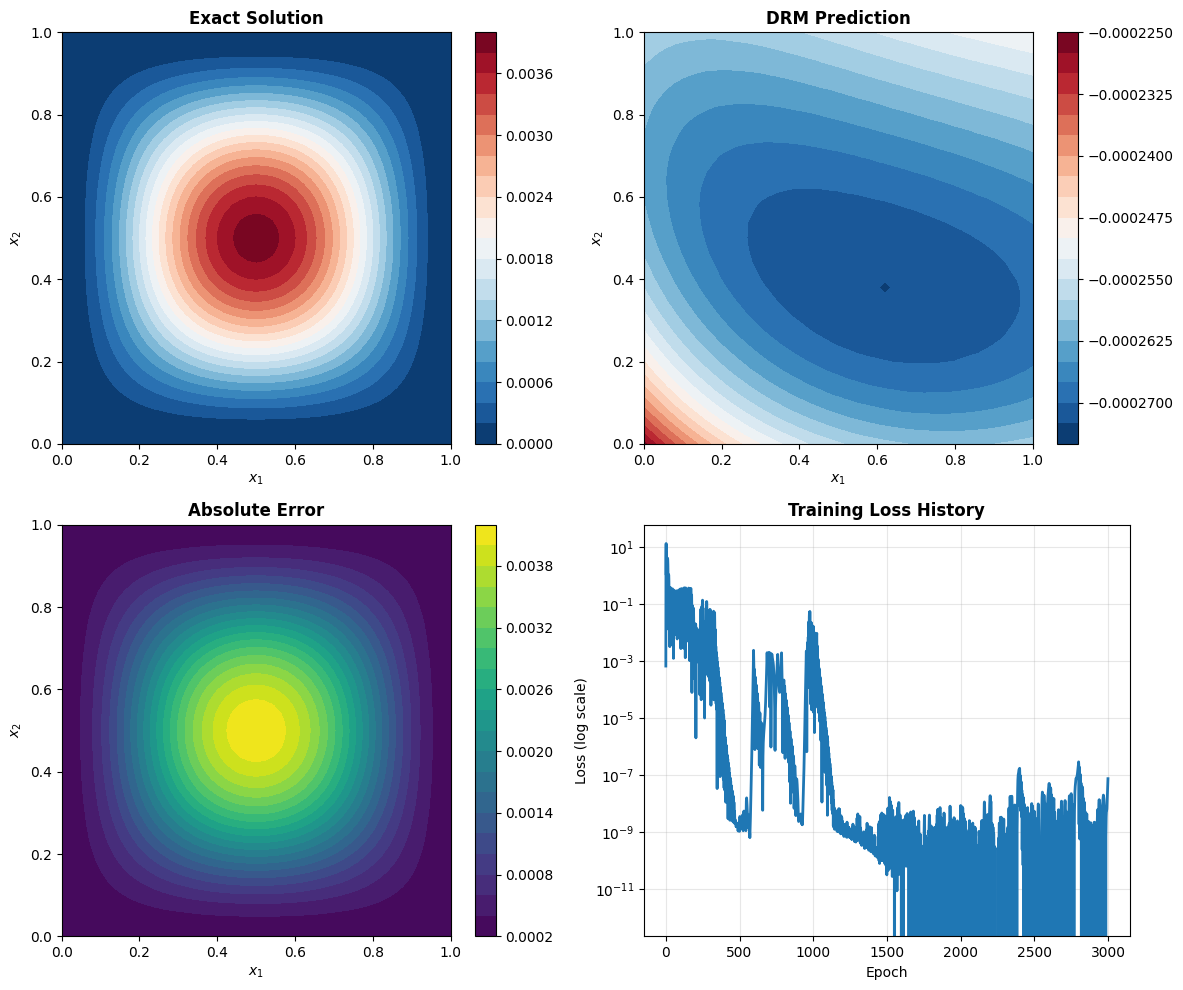

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class NeuralNetwork(nn.Module):
    """Deep neural network for approximating u_theta"""
    def __init__(self, input_dim=2, output_dim=1, layers=4, hidden_dim=64):
        super(NeuralNetwork, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Build network
        layer_list = []
        layer_list.append(nn.Linear(input_dim, hidden_dim))
        layer_list.append(nn.Tanh())
        
        for _ in range(layers - 2):
            layer_list.append(nn.Linear(hidden_dim, hidden_dim))
            layer_list.append(nn.Tanh())
        
        layer_list.append(nn.Linear(hidden_dim, output_dim))
        
        self.net = nn.Sequential(*layer_list)
    
    def forward(self, x):
        return self.net(x)

class BiharmonicP3Solver:
    """Deep Ritz Method solver for P3: simply supported boundary conditions"""
    def __init__(self, network, num_domain=2000, num_boundary=1000, 
                 penalty=1e5, lr=1e-3):
        self.u_theta = network.to(device)
        self.num_domain = num_domain
        self.num_boundary = num_boundary
        self.penalty = penalty
        self.optimizer = torch.optim.Adam(self.u_theta.parameters(), lr=lr, betas=(0.9, 0.999))
        self.history = []
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=200, gamma=0.9)
    
    def sample_interior(self, n_samples):
        """Sample points uniformly from interior Ω = (0,1)²"""
        X = torch.rand(n_samples, 2, device=device)
        X.requires_grad_(True)
        return X
    
    def sample_boundary(self, n_samples):
        """Sample points uniformly from boundary ∂Ω - 25% from each edge"""
        Y = torch.zeros(n_samples, 2, device=device)
        samples_per_edge = n_samples // 4
        
        for edge in range(4):
            start_idx = edge * samples_per_edge
            end_idx = start_idx + samples_per_edge
            
            # Generate random values uniformly on [0, 1]
            t = torch.rand(samples_per_edge, device=device)
            
            if edge == 0:  # x1=0, vary x2
                Y[start_idx:end_idx, 0] = 0.0
                Y[start_idx:end_idx, 1] = t
            elif edge == 1:  # x1=1, vary x2
                Y[start_idx:end_idx, 0] = 1.0
                Y[start_idx:end_idx, 1] = t
            elif edge == 2:  # x2=0, vary x1
                Y[start_idx:end_idx, 0] = t
                Y[start_idx:end_idx, 1] = 0.0
            else:  # x2=1, vary x1
                Y[start_idx:end_idx, 0] = t
                Y[start_idx:end_idx, 1] = 1.0
        
        Y.requires_grad_(True)
        return Y
    
    def compute_laplacian(self, u, x):
        """Compute Laplacian ∇²u"""
        grad_u = torch.autograd.grad(u.sum(), x, create_graph=True, retain_graph=True)[0]
        u_xx = torch.autograd.grad(grad_u[:, 0].sum(), x, create_graph=True, retain_graph=True)[0][:, 0]
        u_yy = torch.autograd.grad(grad_u[:, 1].sum(), x, create_graph=True, retain_graph=True)[0][:, 1]
        laplacian = u_xx + u_yy
        return laplacian
    
    def compute_normal_derivative(self, u, y):
        """Compute ∂u/∂n (normal derivative on boundary)"""
        grad_u = torch.autograd.grad(u.sum(), y, create_graph=True, retain_graph=True)[0]
        
        # Determine normal vector for each boundary point
        n_vec = torch.zeros_like(grad_u)
        
        tol = 1e-6
        # x1 = 0 edge, normal = (-1, 0)
        mask = y[:, 0] < tol
        n_vec[mask, 0] = -1.0
        
        # x1 = 1 edge, normal = (1, 0)
        mask = y[:, 0] > 1.0 - tol
        n_vec[mask, 0] = 1.0
        
        # x2 = 0 edge, normal = (0, -1)
        mask = y[:, 1] < tol
        n_vec[mask, 1] = -1.0
        
        # x2 = 1 edge, normal = (0, 1)
        mask = y[:, 1] > 1.0 - tol
        n_vec[mask, 1] = 1.0
        
        du_dn = (grad_u * n_vec).sum(dim=1)
        return du_dn
    
    def empirical_loss(self, X, Y, f, g1, g2):
        """
        Compute empirical loss for P3:
        L_λ = |Ω|/N Σ B_u(X_i) + |∂Ω|/M Σ [-g2(Y_j)∂u/∂n(Y_j) + λ/2(u-g1)²(Y_j)]
        where B_u(X) = 1/2|Δu(X)|² - f(X)u(X)
        """
        # Domain term
        u_X = self.u_theta(X)
        laplacian_X = self.compute_laplacian(u_X, X)
        
        B_u_X = 0.5 * laplacian_X**2 - f(X) * u_X.squeeze()
        
        # Clamp to avoid NaN
        B_u_X = torch.clamp(B_u_X, min=-1e8, max=1e8)
        domain_loss = (1.0 / self.num_domain) * B_u_X.mean()
        
        # Boundary term
        u_Y = self.u_theta(Y).squeeze()
        du_dn_Y = self.compute_normal_derivative(u_Y, Y)
        
        boundary_g2_term = -g2(Y) * du_dn_Y
        boundary_penalty = (self.penalty / 2) * (u_Y - g1(Y))**2
        
        # Clamp boundary terms
        boundary_g2_term = torch.clamp(boundary_g2_term, min=-1e8, max=1e8)
        boundary_penalty = torch.clamp(boundary_penalty, min=0, max=1e8)
        
        boundary_loss = (1.0 / self.num_boundary) * (boundary_g2_term + boundary_penalty).mean()
        
        total_loss = domain_loss + boundary_loss
        return total_loss, domain_loss, boundary_loss
    
    def train(self, f, g1, g2, epochs=500):
        """Train the network using Adam with learning rate scheduling"""
        for epoch in range(epochs):
            # Sample points
            X = self.sample_interior(self.num_domain)
            Y = self.sample_boundary(self.num_boundary)
            
            # Zero gradients
            self.optimizer.zero_grad()
            
            # Compute loss
            loss, loss_domain, loss_boundary = self.empirical_loss(X, Y, f, g1, g2)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.u_theta.parameters(), max_norm=1.0)
            
            # Optimizer step
            self.optimizer.step()
            
            # Learning rate scheduling
            self.scheduler.step()
            
            self.history.append(loss.item())
            
            if (epoch + 1) % 50 == 0:
                print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.6e} | "
                      f"Domain: {loss_domain.item():.6e} | Boundary: {loss_boundary.item():.6e} | "
                      f"LR: {self.optimizer.param_groups[0]['lr']:.6e}")
    
    def evaluate(self, x_test):
        """Evaluate network at test points"""
        x_tensor = torch.tensor(x_test, dtype=torch.float32, device=device)
        with torch.no_grad():
            u_pred = self.u_theta(x_tensor).cpu().numpy()
        return u_pred

# Example 3.1: u = sin(πx₁)sin(πx₂)/(2π²)
print("=" * 70)
print("Example 3.2: u = x₁²x₂²(1-x₁)²(1-x₂)²")
print("=" * 70)

# Exact solution
def u_exact(x):
    return (x[:, 0]**2 * x[:, 1]**2 * (1 - x[:, 0])**2 * (1 - x[:, 1])**2)

# Right-hand side f = Δ²u (computed analytically)
def f(x):
    x_np = x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x
    x1, x2 = x_np[:, 0], x_np[:, 1]
    
    # Analytical Δ²u for u = x1²x2²(1-x1)²(1-x2)²
    # First Laplacian: Δu = u_xx + u_yy
    u_xx = 2*x2**2*(1-x2)**2*(6*x1**2 - 6*x1 + 1)
    u_yy = 2*x1**2*(1-x1)**2*(6*x2**2 - 6*x2 + 1)
    delta_u = u_xx + u_yy
    
    # Second Laplacian: Δ²u = Δ(Δu)
    # d²(Δu)/dx1² + d²(Δu)/dx2²
    d2delta_u_dx1 = 2*x2**2*(1-x2)**2*(12*x1 - 6) + 4*x1*(1-x1)*(6*x2**2 - 6*x2 + 1)*(6*x1 - 6) + 2*x1**2*(1-x1)**2*0
    d2delta_u_dx2 = 2*x1**2*(1-x1)**2*(12*x2 - 6) + 4*x2*(1-x2)*(6*x1**2 - 6*x1 + 1)*(6*x2 - 6) + 2*x2**2*(1-x2)**2*0
    
    bilaplacian = (12*x2**2*(1-x2)**2*(6*x1**2-6*x1+1) + 
                   24*x1*(1-2*x1)*(6*x2**2-6*x2+1) + 
                   12*x1**2*(1-x1)**2*(6*x2**2-6*x2+1) +
                   12*x1**2*(1-x1)**2*(6*x1**2-6*x1+1))
    
    return torch.tensor(bilaplacian, dtype=torch.float32, device=device)

# Boundary conditions: g1 = u, g2 = Δu on ∂Ω
def g1(y):
    y_np = y.detach().cpu().numpy()
    return torch.tensor(u_exact(y_np), dtype=torch.float32, device=device).squeeze()

def g2(y):
    y_np = y.detach().cpu().numpy()
    x1, x2 = y_np[:, 0], y_np[:, 1]
    # g2 = Δu on boundary
    laplacian = (2*x2**2*(1-x2)**2*(6*x1**2 - 6*x1 + 1) + 
                 2*x1**2*(1-x1)**2*(6*x2**2 - 6*x2 + 1))
    return torch.tensor(laplacian, dtype=torch.float32, device=device)

# Create solver
network = NeuralNetwork(layers=5, hidden_dim=128)
solver = BiharmonicP3Solver(network, num_domain=8000, num_boundary=3000, 
                           penalty=1e4, lr=1e-2)

print("\nTraining DRM solver...")
solver.train(f, g1, g2, epochs=3000)

# Evaluate on grid
print("\nEvaluating on grid...")
x = np.linspace(0, 1, 51)
y = np.linspace(0, 1, 51)
X_grid, Y_grid = np.meshgrid(x, y)
X_test = np.column_stack([X_grid.ravel(), Y_grid.ravel()])

u_pred = solver.evaluate(X_test).reshape(X_grid.shape)
u_exact_grid = u_exact(X_test).reshape(X_grid.shape)
error = np.abs(u_pred - u_exact_grid)

# Compute gradients for error metrics
dx = 1.0 / 50  # Grid spacing
grad_u_exact = np.gradient(u_exact_grid, dx, axis=[0, 1])
grad_u_pred = np.gradient(u_pred, dx, axis=[0, 1])

# Compute second derivatives for H2
hess_u_exact_xx = np.gradient(grad_u_exact[0], dx, axis=0)
hess_u_exact_yy = np.gradient(grad_u_exact[1], dx, axis=1)
hess_u_pred_xx = np.gradient(grad_u_pred[0], dx, axis=0)
hess_u_pred_yy = np.gradient(grad_u_pred[1], dx, axis=1)

# L2 error: ||u - u_θ||_L2(Ω)
error_L2 = np.sqrt(np.sum(error**2) * dx**2)

# Gradient error: ||∇(u - u_θ)||_L2(Ω)
grad_error = np.sqrt(np.sum((grad_u_exact[0] - grad_u_pred[0])**2 + 
                             (grad_u_exact[1] - grad_u_pred[1])**2) * dx**2)

# Second derivative error: ||D²(u - u_θ)||_L2(Ω)
second_deriv_error = np.sqrt(np.sum((hess_u_exact_xx - hess_u_pred_xx)**2 + 
                                     (hess_u_exact_yy - hess_u_pred_yy)**2) * dx**2)

# Energy error: ||u - u_θ||_L2(Ω) + ||∇(u - u_θ)||_L2(Ω)
energy_error = error_L2 + grad_error

# H2 error: ||u - u_θ||_H2(Ω)
h2_error = np.sqrt(error_L2**2 + grad_error**2 + second_deriv_error**2)

# L2 norm of exact solution: ||u||_L2(Ω)
norm_u_L2 = np.sqrt(np.sum(u_exact_grid**2) * dx**2)

# L2 norm of gradient: ||∇u||_L2(Ω)
norm_grad_u_L2 = np.sqrt(np.sum(grad_u_exact[0]**2 + grad_u_exact[1]**2) * dx**2)

# L2 norm of second derivatives: ||D²u||_L2(Ω)
norm_second_deriv_u_L2 = np.sqrt(np.sum(hess_u_exact_xx**2 + hess_u_exact_yy**2) * dx**2)

# H1 norm: ||u||_H1(Ω) = ||u||_L2(Ω) + ||∇u||_L2(Ω)
norm_u_H1 = norm_u_L2 + norm_grad_u_L2

# H2 norm: ||u||_H2(Ω) = ||u||_L2(Ω) + ||∇u||_L2(Ω) + ||D²u||_L2(Ω)
norm_u_H2 = norm_u_L2 + norm_grad_u_L2 + norm_second_deriv_u_L2

# L2 relative error: ||u - u_θ||_L2 / ||u||_L2
l2_relative = error_L2 / norm_u_L2

# H1 relative error (energy relative): (||u - u_θ||_L2 + ||∇(u - u_θ)||_L2) / (||u||_L2 + ||∇u||_L2)
h1_relative = energy_error / norm_u_H1

# H2 relative error: ||u - u_θ||_H2 / ||u||_H2
h2_relative = h2_error / norm_u_H2

print(f"\n" + "=" * 70)
print("RESULTS FOR EXAMPLE 3.1")
print("=" * 70)
print(f"\nL² ERRORS:")
print(f"  ||u - u_θ||_L2(Ω):           {error_L2:.6e}")
print(f"  L² Relative Error:           {l2_relative:.6e}")

print(f"\nENERGY ERRORS (H¹ Relative):")
print(f"  ||u - u_θ||_L2 + ||∇(u - u_θ)||_L2:  {energy_error:.6e}")
print(f"  H¹ Relative Error:                    {h1_relative:.6e}")

print(f"\nH² ERRORS:")
print(f"  ||u - u_θ||_H2(Ω):           {h2_error:.6e}")
print(f"  H² Relative Error:           {h2_relative:.6e}")

print(f"\nADDITIONAL METRICS:")
print(f"  Maximum Absolute Error:      {np.max(error):.6e}")
print(f"  Mean Absolute Error:         {np.mean(error):.6e}")

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Exact solution
im0 = axes[0, 0].contourf(X_grid, Y_grid, u_exact_grid, 20, cmap='RdBu_r')
axes[0, 0].set_title('Exact Solution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('$x_1$')
axes[0, 0].set_ylabel('$x_2$')
plt.colorbar(im0, ax=axes[0, 0])

# DRM prediction
im1 = axes[0, 1].contourf(X_grid, Y_grid, u_pred, 20, cmap='RdBu_r')
axes[0, 1].set_title('DRM Prediction', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('$x_1$')
axes[0, 1].set_ylabel('$x_2$')
plt.colorbar(im1, ax=axes[0, 1])

# Absolute error
im2 = axes[1, 0].contourf(X_grid, Y_grid, error, 20, cmap='viridis')
axes[1, 0].set_title('Absolute Error', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('$x_1$')
axes[1, 0].set_ylabel('$x_2$')
plt.colorbar(im2, ax=axes[1, 0])

# Training history
axes[1, 1].semilogy(solver.history, linewidth=2)
axes[1, 1].set_title('Training Loss History', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss (log scale)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('example_3_1_results.png', dpi=150, bbox_inches='tight')
print("\nPlot saved as 'example_3_1_results.png'")
plt.show()